# <center> Advanced Lane Detection Project </center>

The goals / steps of this project are the following:

<li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.</li>
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import pickle
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt


nx = 9
ny = 6

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension



In [2]:
#Image coversion functions

def convert_image(image, img_format):
    #convert to grayscale
    if img_format == 'gray':
        #print("convert to grayscale")
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray
    elif img_format == 'hls':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        return hls

In [3]:
def detect_corners(img):
    global objpoints, imgpoints
    #print(nx,  ny)
    #print(gray.shape)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    #convert to grayscale
    gray = convert_image(img, 'gray')
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print( ret, corners)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)



In [4]:
#calibration and undistortion

def calibrate(objpoints, imgpoints, img_size):
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret, mtx, dist, rvecs, tvecs

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

found  20  images
Found objpoints  17
Found imgpoints  17


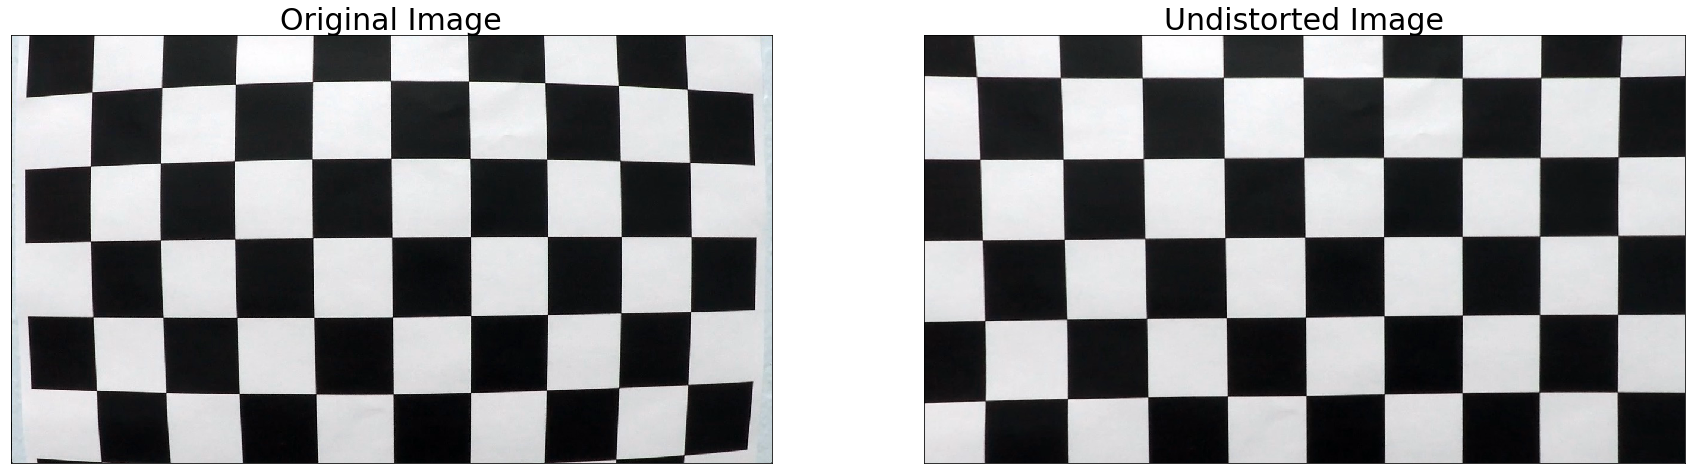

In [5]:
%matplotlib inline

#test calibration
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
print("found ", len(images), " images")

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    #print("calibrate image ", fname)
    
    img = cv2.imread(fname)
    #print('original shape',img.shape)

    #find corners 
    detect_corners(img)
print("Found objpoints ", len(objpoints))
print("Found imgpoints ", len(imgpoints))
    
 
# test calibration on the first image
img = cv2.imread('camera_cal/calibration1.jpg')
 
img_size = (img.shape[1], img.shape[0])
#print(img_size)
ret, mtx, dist, rvecs, tvecs = calibrate(objpoints, imgpoints, img_size)

# Save the camera calibration coefficents
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

dst = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20), subplot_kw={'xticks': [], 'yticks': []})
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
    
    

found  8  images


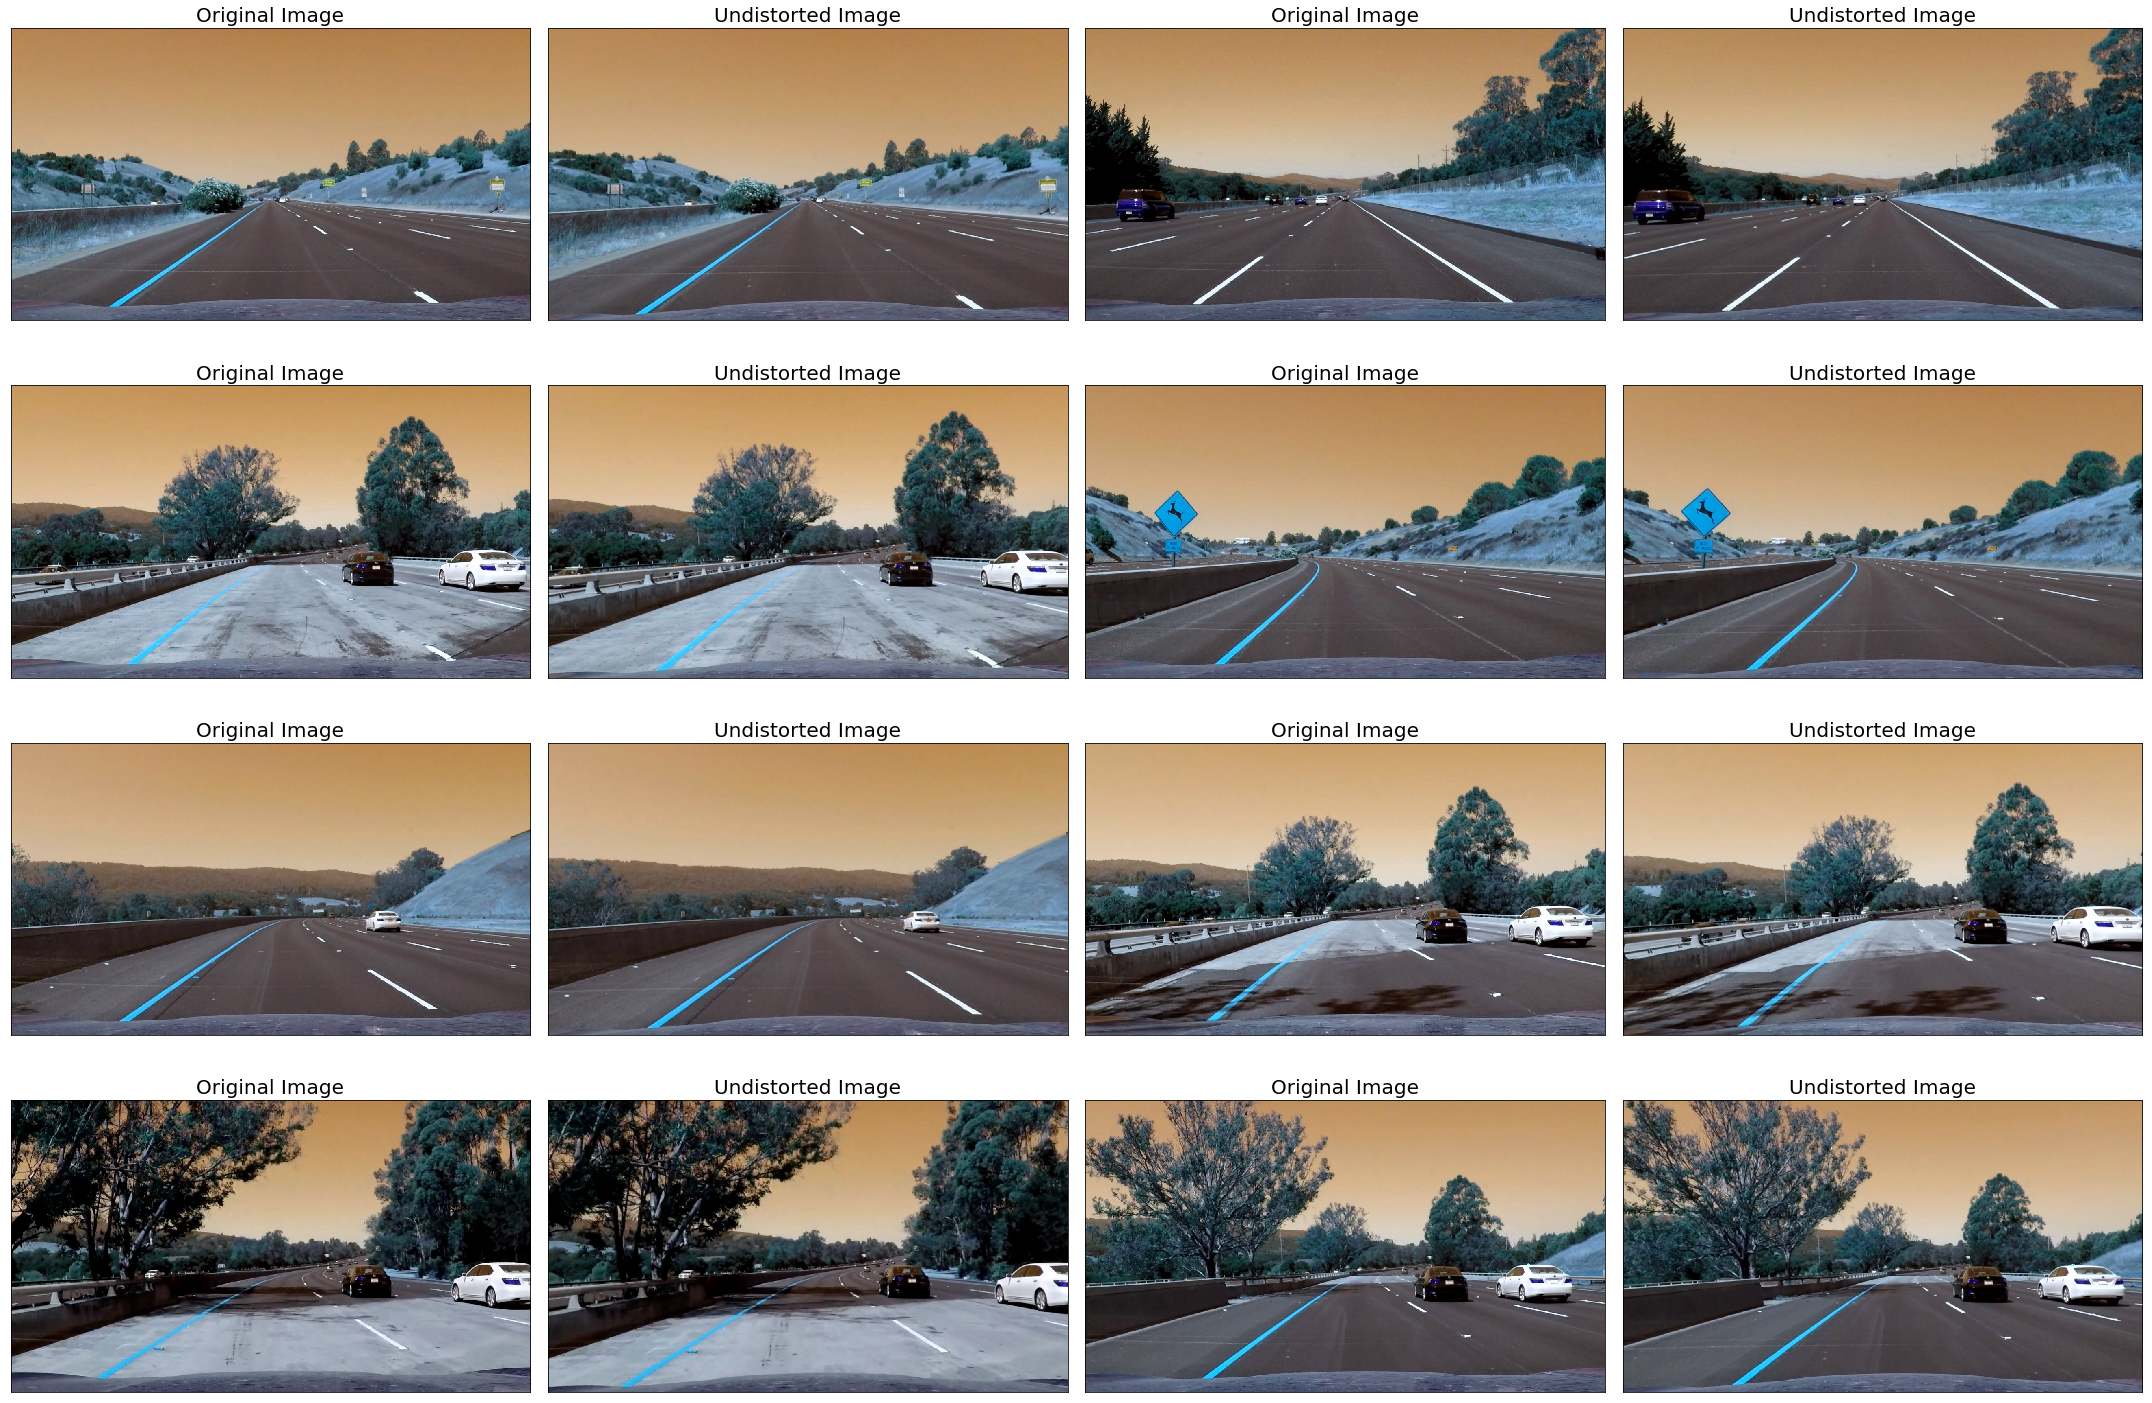

In [6]:
#test calibration on test images
images = glob.glob('test_images/*.jpg')
print("found ", len(images), " images")

f, axes = plt.subplots(4, 4, figsize=(30,20), subplot_kw={'xticks': [], 'yticks': []})
f.tight_layout()
axes = axes.ravel()
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    #print("calibrate image ", fname)
    
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
 
    dst = undistort(img, mtx, dist)

    axes[idx*2].imshow(img)
    axes[idx*2].set_title('Original Image', fontsize=20)
    axes[idx*2+1].imshow(dst)
    axes[idx*2+1].set_title('Undistorted Image', fontsize=20)


In [7]:
def color_thresh(img):
    # Threshold color channel
    s_thresh_min = 125
    s_thresh_max = 255

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = convert_image(img, 'hls')
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary
    
def abs_sobel_thresh(img):    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = convert_image(img, 'gray')

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 25
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary
    
def threshold_binary_image(img, showimage = False):
    s_binary = color_thresh(img)
    sxbinary = abs_sobel_thresh(img)
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    if showimage == True:
        # Plotting thresholded images
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('Original')
        ax1.imshow(img)

        ax2.set_title('Stacked thresholds')
        ax2.imshow(color_binary)

        ax3.set_title('Combined S channel and gradient thresholds')
        ax3.imshow(combined_binary, cmap='gray')
    return combined_binary

array([[1, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 1, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

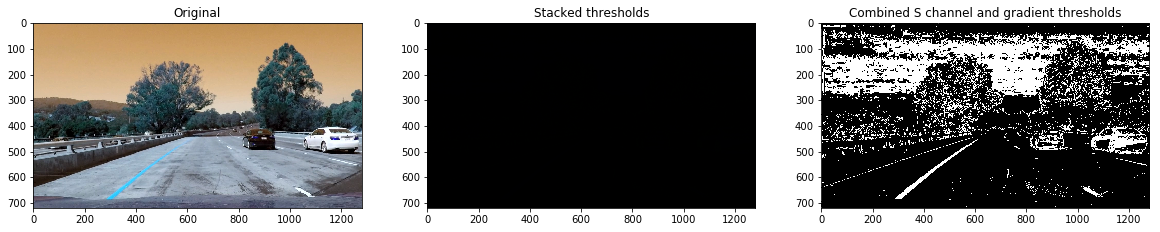

In [8]:
#test color transform, gradient
img = cv2.imread('test_images/test1.jpg')
threshold_binary_image(img, True)

In [9]:
def unwarp(img):
    img_size = (img.shape[1], img.shape[0])

    # Source points - defined area of lane line edges
    #src = np.float32([(570,464),
    #                  (707,464), 
    #                  (260,664), 
    #                  (1050,664)])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                    [((img_size[0] / 6) - 10), img_size[1]],
                    [(img_size[0] * 5 / 6) + 60, img_size[1]],
                    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    offset = 100
    #dst = np.float32([[offset, offset], 
    #                  [img_size[0]-offset, offset], 
    #                  [img_size[0]-offset, img_size[1]-offset], 
    #                  [offset, img_size[1]-offset]])
    dst = np.float32([[(img_size[0] / 4), 0],
                    [(img_size[0] / 4), img_size[1]],
                    [(img_size[0] * 3 / 4), img_size[1]],
                    [(img_size[0] * 3 / 4), 0]])

    #Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    #Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

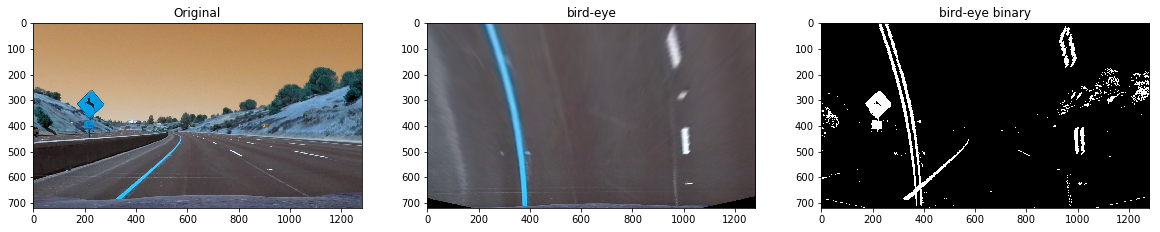

In [10]:
# Load pickled matrix and distortion coefficients
with open('calibration.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
#test warp
img = cv2.imread('test_images/test2.jpg')

dst_img = undistort(img, mtx, dist)
warped, Minv = unwarp(dst_img)
binary = threshold_binary_image(warped)


#threshold_binary_image(img, True)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(img)

ax2.set_title('bird-eye')
ax2.imshow(warped, cmap='gray')

ax3.set_title('bird-eye binary')
ax3.imshow(binary, cmap='gray')



In [11]:
def finding_lanes(binary_warped):
    global xm_per_pix
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #print(binary_warped.shape)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #print(win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high ))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
 
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, nonzerox, nonzeroy

def polyfit(binary_warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def offset(binary_warped, left_fitx, right_fitx):
    #determine offset
    car_center = binary_warped.shape[1]/2
    lane_center = (left_fitx + right_fitx)/2
    offset = (car_center - lane_center) * xm_per_pix
    #print ('offset - ', offset)
    return offset

def find_curvature(ploty, leftx, rightx, debug=False):
    global xm_per_pix, ym_per_pix
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    if debug:
        print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad
    
def previous_frame(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

In [12]:
def visualize(flag, binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit, rectangle_data):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    if flag == 1:
        for rect in rectangle_data:
            # Draw the windows on the visualization image
        #    print(rect)
            cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
            cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
        # Write the results on images using OpenCV 
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_size = 1.5
        color = (255,255,255)
        text_left = "{:6.5}y^2+{:6.5}y+{:6.5}".format(left_fit[0],left_fit[1],left_fit[2])
        cv2.putText(out_img, text_left, (20, 100), font, font_size, color, 2)
        text_right = "{:6.5}y^2+{:6.5}y+{:6.5}".format(right_fit[0],right_fit[1],right_fit[2])
        cv2.putText(out_img, text_right, (360, 600), font, font_size, color, 2)    
    
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    elif flag ==2:
        # Create an image to draw on and an image to show the selection window
        margin = 100
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)


(720, 1280)


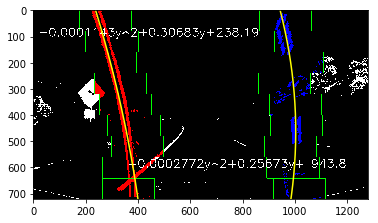

In [13]:
# Load pickled matrix and distortion coefficients
with open('calibration.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
#test finding lanes
img = cv2.imread('test_images/test2.jpg')

dst_img = undistort(img, mtx, dist)
warped, Minv = unwarp(dst_img)
binary = threshold_binary_image(warped)
print (binary.shape)
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, nonzerox, nonzeroy = finding_lanes(binary)
ploty, left_fitx, right_fitx = polyfit(binary, left_fit, right_fit)
#find offset
offset = offset(binary, left_fitx, right_fitx)
#find curvature
curve = find_curvature(ploty, left_fitx, right_fitx)
#visualize 1
visualize(1, binary, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit, rectangle_data)


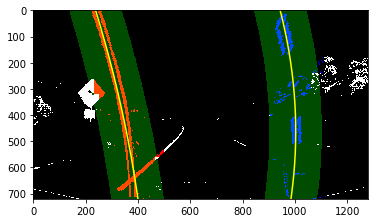

In [14]:
# visualize 2
visualize(2, binary, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit, rectangle_data)


In [15]:
def drawing_lane(undist, binary_warped, ploty, left_fitx, right_fitx, Minv):
    
    img_size = (undist.shape[1], undist.shape[0])
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

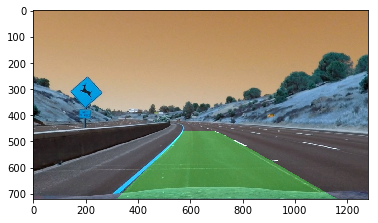

In [16]:
# Load pickled matrix and distortion coefficients
with open('calibration.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
# t#test finding curve
img = cv2.imread('test_images/test2.jpg')

dst_img = undistort(img, mtx, dist)
warped, Minv = unwarp(dst_img)
binary = threshold_binary_image(warped)
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, nonzerox, nonzeroy = finding_lanes(binary)
ploty, left_fitx, right_fitx = polyfit(binary, left_fit, right_fit)
result = drawing_lane(dst_img, binary, ploty, left_fitx, right_fitx, Minv)
plt.imshow(result)

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

left_line = Line()
right_line = Line()

In [18]:
# Load pickled matrix and distortion coefficients
with open('calibration.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
def pipeline(img):
    global left_line, right_line
    
    dst_img = undistort(img, mtx, dist)
    warped, Minv = unwarp(dst_img)
    binary = threshold_binary_image(warped)
    
    if left_line.detected == False and right_line.detected == False:
        #left_line.detected = True
        #right_line.detect = True
        
        left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, nonzerox, nonzeroy = finding_lanes(binary)
        ploty, left_fitx, right_fitx = polyfit(binary, left_fit, right_fit)
        #find curvature
        left_curverad, right_curverad = find_curvature(ploty, left_fitx, right_fitx)
        left_line.current_fit = left_fit
        left_line.best_fit = left_fitx
        left_line.radius_of_curvature = left_curverad
        right_line.current_fit = right_fit
        right_line.best_fit = right_fitx
        right_line.radius_of_curvature = right_curverad
        
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, nonzerox, nonzeroy = previous_frame(binary, left_line.current_fit, right_line.current_fit)
        ploty, left_fitx, right_fitx = polyfit(binary, left_fit, right_fit)
        curve = find_curvature(ploty, left_fitx, right_fitx)
        
    result = drawing_lane(dst_img, binary, ploty, left_fitx, right_fitx, Minv)
    return result

In [19]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:08<00:00,  7.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 21s, sys: 33.4 s, total: 3min 54s
Wall time: 3min 9s
